In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'


# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import ffn

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from utils import cprint
from bars import *

RANDOM_STATE = 777

# SKLearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report


print()
%watermark -p pandas,pandas_datareader,dask,numpy,sklearn,statsmodels,scipy,ffn,matplotlib,seaborn

2018-09-29T21:28:25+08:00

CPython 3.6.6
IPython 6.5.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit

pandas 0.23.4
pandas_datareader 0.7.0
dask 0.19.1
numpy 1.15.1
sklearn 0.19.2
statsmodels 0.9.0
scipy 1.1.0
ffn (0, 3, 4)
matplotlib 3.0.0
seaborn 0.9.0


In [2]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [3]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
df = pd.read_parquet(infp)
dbars = dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()
close = dbars.price.copy()
dailyVol = getDailyVol(close)
cprint(dailyVol.to_frame())

100%|██████████| 941297/941297 [00:00<00:00, 2288116.64it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dailyVol
2018-02-26 15:31:06  0.006852
2018-02-26 15:40:15  0.006893
2018-02-26 15:49:42  0.006889
2018-02-26 15:59:04  0.006894
2018-02-26 16:16:14  0.006902
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30843 entries, 2009-09-29 10:03:18 to 2018-02-26 16:16:14
Data columns (total 1 columns):
dailyVol    30842 non-null float64
dtypes: float64(1)
memory usage: 481.9 KB
None
-------------------------------------------------------------------------------



## Bollinger

In [4]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [5]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
cprint(bb_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price      ave    upper    lower
2018-02-26 15:31:06  115.29  114.005  114.959  113.051
2018-02-26 15:40:15  115.41  114.069  115.008  113.129
2018-02-26 15:49:42  115.20  114.124  115.047  113.202
2018-02-26 15:59:04  115.27  114.183  115.083  113.282
2018-02-26 16:16:14  115.30  114.231  115.125  113.338
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30811 entries, 2009-10-01 15:51:02 to 2018-02-26 16:16:14
Data columns (total 4 columns):
price    30811 non-null float64
ave      30811 non-null float64
upper    30811 non-null float64
lower    30811 non-null float64
dtypes: float64(4)
memory usage: 1.2 MB
None
-------------------------------------------------------------------------------



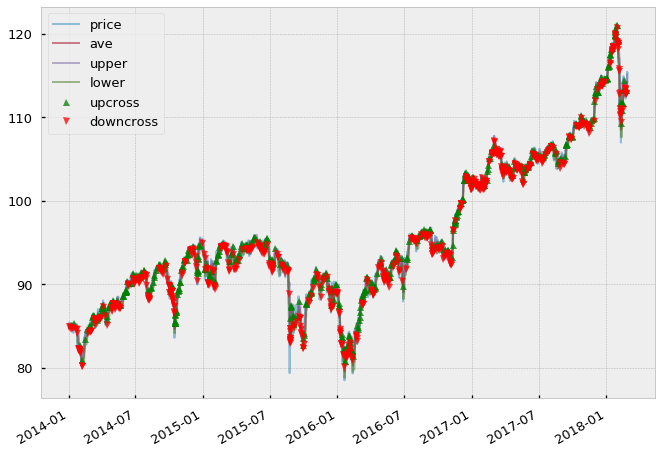

In [6]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc['2014':].plot(ax=ax, alpha=.5)
bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()

In [7]:
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

In [8]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna().abs()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [9]:
tEvents = getTEvents(close,h=dailyVol.mean())


100%|██████████| 30858/30858 [00:02<00:00, 13473.83it/s]


In [10]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

In [11]:
t1 = addVerticalBarrier(tEvents, close)


In [12]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

In [13]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [14]:
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

In [15]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

In [16]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

In [17]:
# create target series
ptsl = [1,1]
target=dailyVol
# select minRet
minRet = 0.01

# Run in single-threaded mode on Windows
import platform
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1
    
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)

2018-09-29 21:28:33.013162 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


2018-09-29 21:28:33.980398 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


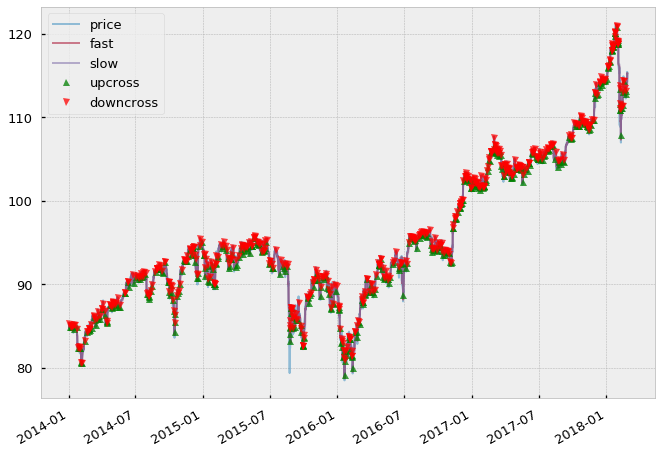

In [18]:
# ma
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
# cprint(side)
minRet = .01 
ptsl=[1,2]
ma_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=side)
# cprint(ma_events)
ma_events.side.value_counts()
ma_side = ma_events.dropna().side

In [19]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here


In [20]:
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

In [21]:
#df_rolling_autocorr(d1, window=21).dropna().head()
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')

# get side
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()

minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
bb_side = bb_events.dropna().side
bb_bins = getBins(bb_events,close).dropna()


2018-09-29 21:28:35.314699 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


In [22]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())


             precision    recall  f1-score   support

   no_trade       0.58      0.56      0.57        27
      trade       0.60      0.62      0.61        29

avg / total       0.59      0.59      0.59        56



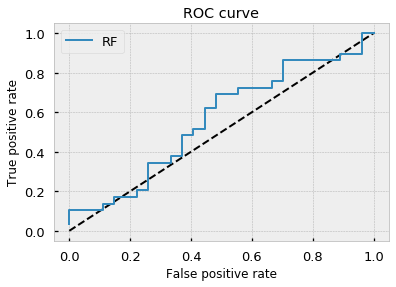

In [23]:
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [24]:

# Add in the side for next section to take trades
bb_side_raw.to_frame()
Xy_side = (pd.merge_asof(Xy, bb_side_raw.to_frame(),
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
Xy_side.columns = ['vol', 'ma_side', 'srl_corr', 'bin', 'bb_side']



# Split up the code, use RF to train and then take actions
Xy_oos = Xy_side[:56]
X_oos = Xy_oos.drop('bin',axis=1).drop('bb_side', axis=1).values
y_oos = rf.predict(X_oos)


# Put the prediction into a data frame
pred_df = pd.DataFrame(index=Xy_oos.index, data=y_oos, columns=['prediction'])
Xy_predicted = (pd.merge_asof(Xy_oos, pred_df,
                    left_index=True, right_index=True, 
                    direction='forward').dropna())




In [25]:
trades_list = Xy_predicted

# make a trade list and drop old columns
trades_list = trades_list.drop('ma_side', axis=1).drop('srl_corr', axis=1).drop('bin', axis=1)
trades_list = trades_list.rename(columns={'vol': 'target_stop',
                                         'bb_side': 'direction',
                                         'prediction': 'trade_entry'})

# drop no-trades
idx_trigger_entry = (trades_list['trade_entry'] == 1)
trades_list = trades_list[idx_trigger_entry]


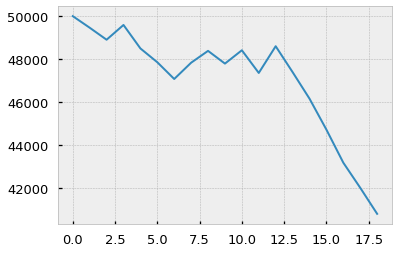

In [26]:
# trades_list, cprint(close.to_frame())
# event_driven_trading = (pd.merge_asof(close.to_frame(),trades_list, 
#                                       left_index=True, right_index=True, 
#                                       direction='forward').dropna())

event_driven_trading = pd.merge( trades_list,  close.to_frame(), 
                                how='outer',
                                left_index=True, right_index=True)



# cprint(event_driven_trading)
# event_driven_trading

start_equity = 50000

equity = [start_equity,]
in_position = False
entry_price = None
tp_price = None
stop_price = None
current_direction = None
for idx, row in event_driven_trading.iterrows():
    if not in_position and not pd.isna(row['trade_entry']):
        in_position = True
        entry_price = row['price']
        current_direction = row['trade_entry']
        
        if row['direction'] == 1:
            tp_price = row['price']*(1+row['target_stop'])
            stop_price = row['price']*(1-row['target_stop'])
        else:
            tp_price = row['price']*(1-row['target_stop'])
            stop_price = row['price']*(1+row['target_stop'])

#         print("TP:{} SL:{}".format(tp_price, stop_price))
        continue

    if in_position:
  
        if current_direction == 1 and row['price'] >= tp_price:
            profit_pts = tp_price - entry_price
        elif current_direction == 1 and row['price'] <= stop_price:
            # Lose money
            profit_pts = stop_price - entry_price
        elif current_direction == -1 and row['price'] <= tp_price:
            profit_pts = entry_price - tp_price
        elif current_direction == -1 and row['price'] >= stop_price:
            # Lose money
            profit_pts = entry_price - stop_price
            
        else:
            continue
        profit_dollars = profit_pts * 1000
#         print("Entry:{} Current:{} Profit:{}".format(entry_price,
#                                                      row['price'],
#                                                      profit_dollars))
        equity.append(equity[-1] + profit_dollars)
        in_position = False
        

plt.plot(equity)